In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from time import time
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_validate
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-feb-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-feb-2021/train.csv
/kaggle/input/tabular-playground-series-feb-2021/test.csv


# Data preperation

In [2]:
# import datasets

df_train = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2021/train.csv')

df_test = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2021/test.csv')

df_submission = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2021/sample_submission.csv')

df = pd.concat([df_train.iloc[:, 0:25], df_test])

df = df.iloc[:, 1:]

target = df_train['target']

print('The training set contains ' + str(df_train.shape[0]) + ' rows.')
print('The test set contains ' + str(df_test.shape[0]) + ' rows.')
print('The total number of rows is ' + str(df.shape[0]) + '.')

# remove multiple definitions to save memory space

df_train = None
df_test = None

df.head()

The training set contains 300000 rows.
The test set contains 200000 rows.
The total number of rows is 500000.


,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,A,B,A,A,B,D,A,E,C,I,...,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903
1,B,A,A,A,B,B,A,E,A,F,...,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464
2,A,A,A,C,B,D,A,B,C,N,...,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352
3,A,A,A,C,B,D,A,E,G,K,...,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766
4,A,B,A,A,B,B,A,E,C,F,...,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743


In [3]:
# check for null values

df.isnull().sum()

cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
dtype: int64

In [4]:
# check the correlation between the continuous variables and the target variable

columns = df.columns
for i in range(10, 24):
    column = columns[i]
    correlation = df[column].corr(target, method='pearson')**2
    print(column + ' has a correlation of ' + str(correlation))

cont0 has a correlation of 0.0004865512060751756
cont1 has a correlation of 0.0004440066362373147
cont2 has a correlation of 1.5773740157476955e-06
cont3 has a correlation of 7.962641030207312e-06
cont4 has a correlation of 8.875905406703757e-05
cont5 has a correlation of 0.00020100449283525572
cont6 has a correlation of 5.7203004850676536e-05
cont7 has a correlation of 0.00019384852491226482
cont8 has a correlation of 0.00016599103139424107
cont9 has a correlation of 1.665166661480202e-09
cont10 has a correlation of 0.00015611381783088815
cont11 has a correlation of 0.00013549310110416528
cont12 has a correlation of 6.866939882643463e-06
cont13 has a correlation of 1.4385596657719778e-06


cont0 and cont1 seem to be the most correlated with the target variable but with pretty bad results overall. Let's have a look at both features.

In [5]:
def customized_scatterplot(y, x):
        ## Sizing the plot. 
    plt.subplots(figsize = (12,8))
    sns.scatterplot(y = y, x = x);

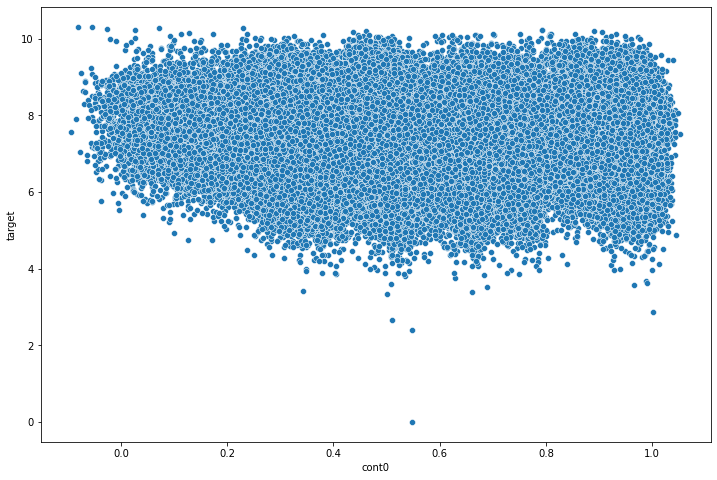

In [6]:
import matplotlib.pyplot as plt

# plot cont0 with respect to the target variable

customized_scatterplot(target, df.iloc[:300000, :].cont0)

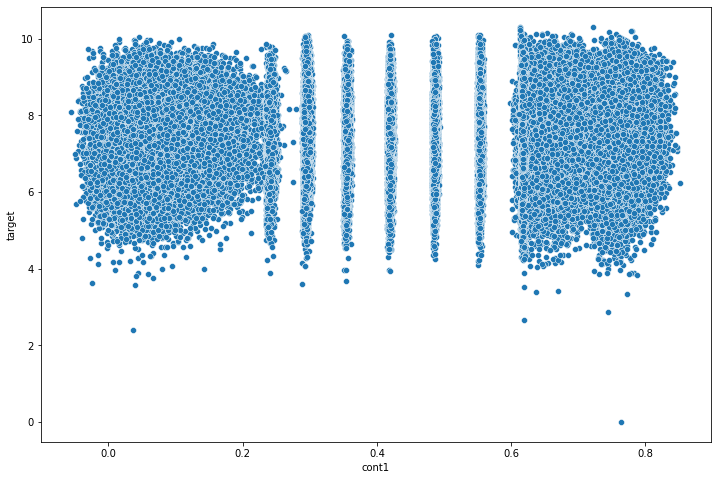

In [7]:
# plot cont1 with respect to the target variable

customized_scatterplot(target, df.iloc[:300000, :].cont1)

Our two most correlated continuous features are cont0 and cont1 and neither are very helpful in predicting the target variable. Hopefully the discrete variables will be more useful. Also there seems to be an outlier in the dataset which might be worth removing.

In [8]:
# lets look at the possible unique values the categorical features offer

for i in range(10):
    print(df.iloc[:,i].unique())

['A' 'B']
['B' 'A']
['A' 'B']
['A' 'C' 'D' 'B']
['B' 'C' 'A' 'D']
['D' 'B' 'A' 'C']
['A' 'B' 'D' 'C' 'E' 'I' 'G' 'H']
['E' 'B' 'D' 'G' 'F' 'A' 'C' 'I']
['C' 'A' 'G' 'E' 'D' 'F' 'B']
['I' 'F' 'N' 'K' 'B' 'L' 'G' 'H' 'O' 'A' 'J' 'M' 'C' 'D' 'E']


In [9]:
# my own label encoder since the scikit learn one is a bit confusing

def encode(dataframe):
    row, columns = dataframe.shape
    column_labels = dataframe.columns
    
    non_categorical_columns_list = []

    for i in column_labels:
        
        # find the unique values
        label_list = list(dataframe[i].unique())
        
        # check if the feature is categorical
        if len(label_list) > 30:
            non_categorical_columns_list.append(i)
            continue  
            
        # encode the labels with integers
        dataframe[i] = dataframe[i].map(lambda x: label_list.index(x))
                
    print('The non-categorical columns are:' + str(non_categorical_columns_list))        
    
    return dataframe

# encode the dataframe

df = encode(df)

df.head()

The non-categorical columns are:['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']


,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,0,0,0,0,0,0,0,0,0,...,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903
1,1,1,0,0,0,1,0,0,1,1,...,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464
2,0,1,0,1,0,0,0,1,0,2,...,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352
3,0,1,0,1,0,0,0,0,2,3,...,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766
4,0,0,0,0,0,1,0,0,0,1,...,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743


In [10]:
# comparing the correlation of label encododed variables and dummy variables

# check the correlation between the categorical variables and the target variable

columns = df.columns
for i in range(10):
    column = columns[i]
    correlation = df[column].corr(target, method='pearson')**2
    print(column + ' has a correlation of ' + str(correlation))

cat0 has a correlation of 0.0010212377803350005
cat1 has a correlation of 0.005331086552063087
cat2 has a correlation of 0.0037156928025265986
cat3 has a correlation of 0.0009833350545357584
cat4 has a correlation of 2.390441079112104e-06
cat5 has a correlation of 0.0010063056503897667
cat6 has a correlation of 0.0009961514912593947
cat7 has a correlation of 4.7059722000659635e-05
cat8 has a correlation of 0.00015628037778336288
cat9 has a correlation of 7.548043363597826e-05


As one might expect, the binary categories are better correlated since they are not affected by the innate bias of label encoding. In light of this, we'll create dummy variables for the non-binary categorical features.

In [11]:
# for each category get it's dummy features and replace the original feature

categorical_features = ['cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']

print('Original number of features: ', df.shape[1])

# get the dummy features

dummies = pd.get_dummies(df[categorical_features].astype(str))

# add them on to the original dataframe

df = pd.concat([df, dummies], axis=1)

# remove the old features

df = df.drop(categorical_features, axis=1)

print('Number of features to be removed: ', len(categorical_features))
print('Number of dummy features to be added: ',dummies.shape[1])
print('New number of features: ',df.shape[1])

Original number of features:  24
Number of features to be removed:  7
Number of dummy features to be added:  50
New number of features:  67


In [12]:
df.head()

,cat0,cat1,cat2,cont0,cont1,cont2,cont3,cont4,cont5,cont6,...,cat9_13,cat9_14,cat9_2,cat9_3,cat9_4,cat9_5,cat9_6,cat9_7,cat9_8,cat9_9
0,0,0,0,0.923191,0.684968,0.124454,0.217886,0.281421,0.881122,0.421650,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0.437627,0.014213,0.357438,0.846127,0.282354,0.440011,0.346230,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0.732209,0.760122,0.454644,0.812990,0.293756,0.914155,0.369602,...,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0.705142,0.771678,0.153735,0.732893,0.769785,0.934138,0.578930,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0.486063,0.639349,0.496212,0.354186,0.279105,0.382600,0.705940,...,0,0,0,0,0,0,0,0,0,0


Now that the features have been redefined we can split the data back into training and testing dataframes.

In [13]:
X = df.iloc[:300000, 0:67]

X_unknown = df.iloc[300000:500000, 0:67]

# KNN

Our first model that we'll be tuning is a K-nearest neighbour model. As we've learnt before, it's best to find the high impact hyperparameters first which in this case will be k.

In [14]:
# count how long it takes

start = time()

# conduct a grid search with chosen parameters on a KNN regression model

knn_parameters = {'n_neighbors':[5, 7, 9, 11]}

# define the model

knn_model = GridSearchCV(KNeighborsRegressor(), knn_parameters, scoring='neg_root_mean_squared_error', n_jobs=4, cv=3)

# fit the model to the numeric training set

#knn_model.fit(X, target)

#print('This model took ' + str((time()-start)/60) + ' minutes to grid search and fit.')

print('This model took ' + str(118.81489472786585) + ' minutes to grid search and fit.')

This model took 118.81489472786585 minutes to grid search and fit.


In [15]:
#knn_model.best_params_, knn_model.best_score_

print('({\'n_neighbors\': 11}, -0.9014691250987212)')

({'n_neighbors': 11}, -0.9014691250987212)


Three things to note from this outcome. Firstly, the score is pretty bad. Our features were poorly correlated with the target and so implies that if there is a relationship between them and the target it must be a complex one, maybe too complex for knn. Secondly, the best permorming number of neighbors was the highest that we gave it which again might follow from a complex relationship. Finally, this grid search took 2 hours to complete. To get good results there will need to be a lot of tuning. In light of this we will try to reduce the number of features to speed up the process.

In light of this we will ignore knn from here on out.

# More data prep

A feature with very low variance is not useful, so let's take a look.

In [16]:
# display columns with low variance

df.var()[df.var() < 0.001].sort_values()

cat6_6     0.000006
cat7_7     0.000010
cat7_6     0.000016
cat6_7     0.000026
cat8_6     0.000048
cat7_5     0.000052
cat6_4     0.000064
cat6_5     0.000080
cat9_14    0.000252
cat9_13    0.000352
cat6_2     0.000546
cat9_12    0.000704
cat7_4     0.000981
dtype: float64

These binary categorical columns have a variance of less than 0.001 meaning that over 99.9% of the values are constant (either 0 or 1). Therefore this columns will be dropped.

In [17]:
columns = list(df.var()[df.var() < 0.001].index)

old_shape = df.shape

df = df.drop(columns, axis=1)

print('The number of columns dropped from ' + str(old_shape[1]) + ' to ' + str(df.shape[1]) + '.')

The number of columns dropped from 67 to 54.


Next let's see if there are any columns that are overly correlated.

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

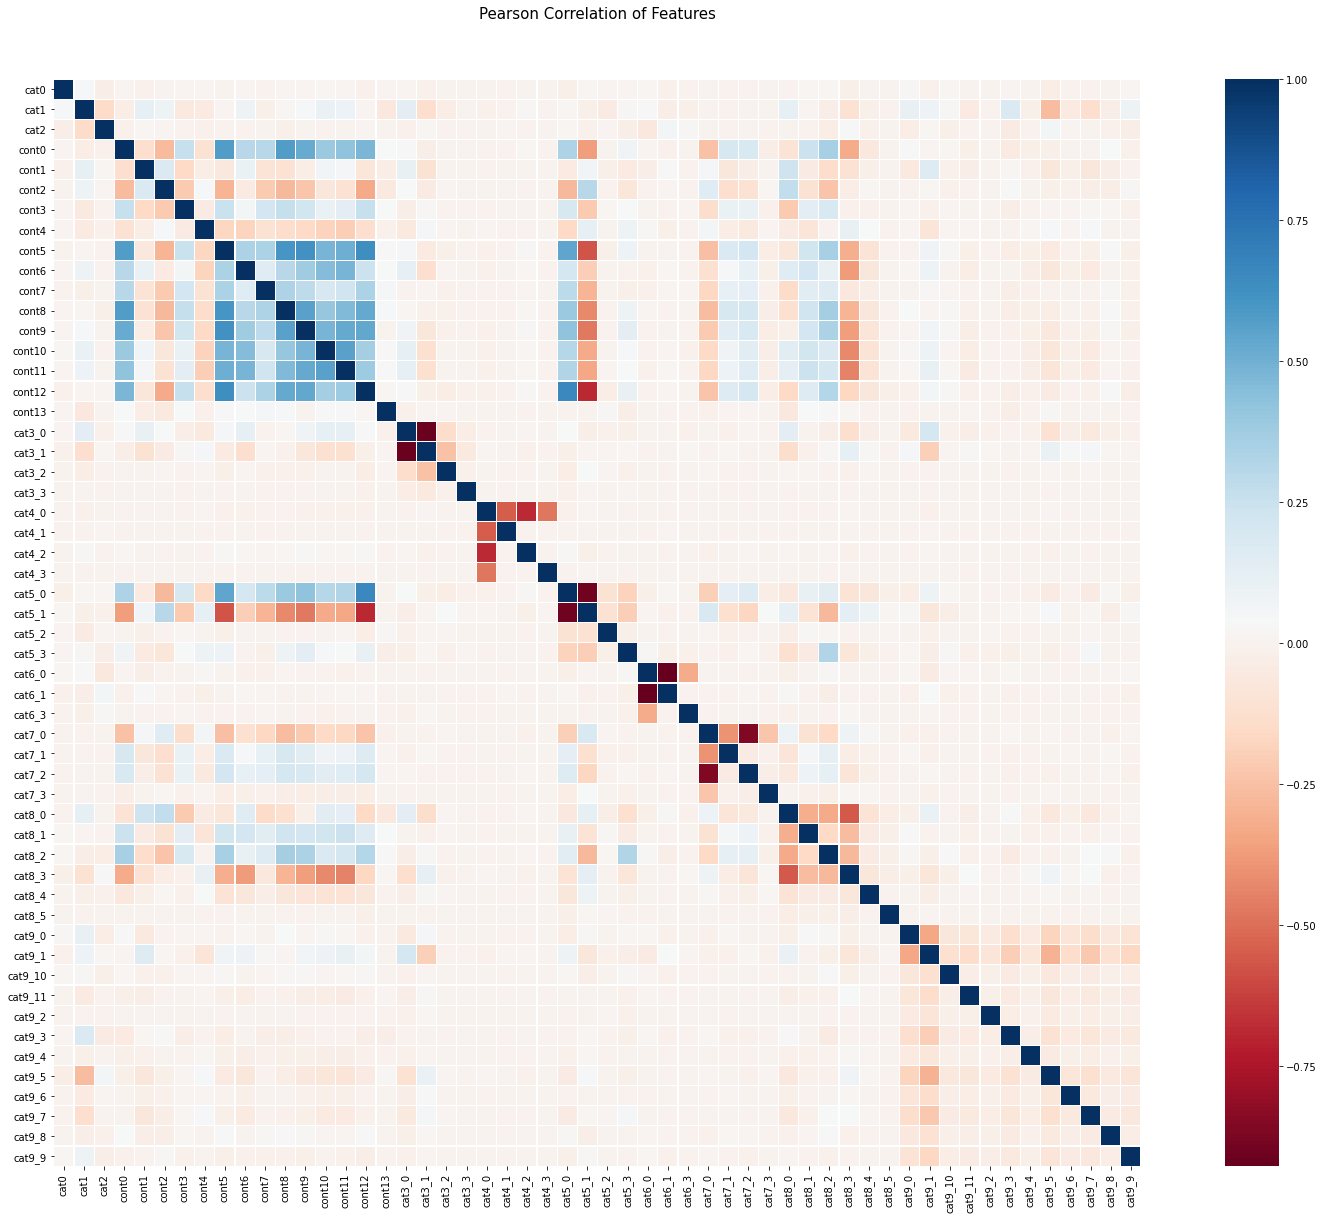

In [18]:
# check the Pearson correlation matrix for strongly correlated features

colormap = plt.cm.RdBu
plt.figure(figsize=(30, 20))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=False)

There aren't any features that seem to demand removal purely from a correlation standpoint. Let's use sklearn's PCA function to reduce the number of features.

In [19]:
# pca - keep 90% of variance

pca = PCA(0.90, svd_solver = 'full')

# fit the PCA

principal_components = pca.fit_transform(df)

# convert df back to a dataframe from nparray

df = pd.DataFrame(data = principal_components)

df.shape

(500000, 24)

In [20]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.081481,0.514582,-0.106633,0.782272,0.532642,-0.600806,-0.187245,-0.146807,0.827785,-0.140631,...,0.186440,-0.071789,-0.039953,-0.078300,0.150935,-0.157243,-0.024033,0.052680,0.253320,-0.470742
1,-0.058784,0.996129,0.537191,-0.300333,0.132141,1.004112,-0.087919,-0.789031,-0.222970,-0.018180,...,-0.263167,-0.197318,0.163304,-0.111654,0.159509,-0.041527,0.071543,-0.064618,-0.289813,0.158225
2,0.969196,-0.358566,-0.871925,-0.232778,0.156225,-0.218497,0.642833,0.256652,-0.135738,0.114243,...,-0.225697,0.080398,-0.140226,-0.113215,0.175876,0.344877,-0.104234,0.238196,0.225077,-0.434414
3,0.972979,-0.731856,-0.325638,-0.443144,0.459483,0.189428,-0.543608,0.426910,-0.552173,0.210222,...,0.045275,-0.104346,0.284659,-0.278580,-0.055971,0.305075,-0.134666,-0.019940,0.428143,0.104597
4,-0.295522,1.299326,-0.003087,0.642581,-0.534063,0.259572,-0.060040,-0.039054,0.259127,0.015038,...,0.127193,-0.120316,-0.043470,0.119430,-0.164513,-0.062641,-0.036509,-0.085269,-0.177538,0.048362


We see that PDS is able to retain 90% of the variance with just 24 columns. The number of features has been greatly reduced, hopefully this will significantly speed up the model training.

# GBR

In [21]:
# redefining the dataframes

X = df.iloc[:300000, 0:67]

X_unknown = df.iloc[300000:500000, 0:67]

Gradient boosted trees will be our first model to tune. First we want to find a good number of esimators, a step by step process can be seen in my MNIST notebook here:

https://www.kaggle.com/hekkta/digit-recogniser-gradient-boost-tuning

In [22]:
# conduct a grid search to find our initial n_estimators and learning rate

variable_parameters = {'n_estimators': range(20, 100, 10), 'learning_rate': [0.1]}

# define the regressor

gbc = GradientBoostingRegressor(
                      min_samples_split=400, # ~1% of total values
                      min_samples_leaf=50, # as recommended
                      max_depth=6, # 5-8 depending on dataset size
                      max_features='sqrt', # as recommended
                      subsample=0.8 # as recommended
                      )

# define the model

model = GridSearchCV(gbc, variable_parameters, scoring='neg_root_mean_squared_error', n_jobs=4, cv=5)

# fit the model to the training set

#start = time()

#model.fit(X, target)

#print('The model took ' + str((time()-start)/60) + ' minutes to fit.')

print('The model took ' + str(19.25663543144862) + ' minutes to fit.')

The model took 19.25663543144862 minutes to complete.


In [23]:
#model.best_params_, model.best_score_

print('({\'learning_rate\': 0.1, 'n_estimators': 90}, -0.8665512498268682)')

({'learning_rate': 0.1, 'n_estimators': 90}, -0.8665512498268682)

As onemight expect, a high number of estimators was the optimal amount. This means that the following tuning will take more time than is ideal as it has to calculate 90 trees for each run through.

In [25]:
# conduct a grid search to find the optimal high impact tree specific parameters

variable_parameters = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}


# define the regressor

gbc = GradientBoostingRegressor(
                      learning_rate=0.1, # as found
                      n_estimators=90, # as found
                      min_samples_leaf=50, # as recommended
                      max_features='sqrt', # as recommended
                      subsample=0.8 # as recommended
                      )

# define the model

model = GridSearchCV(gbc, variable_parameters, scoring='neg_root_mean_squared_error', n_jobs=4, cv=5)

# fit the model to the training set

start = time()

#model.fit(X, target)

#print('The model took ' + str((time()-start)/60) + ' minutes to fit.')

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(max_features='sqrt',
                                                 min_samples_leaf=50,
                                                 n_estimators=90,
                                                 subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(200, 1001, 200)},
             scoring='neg_root_mean_squared_error')

In [28]:
#model.best_params_, model.best_score_

print(({\'max_depth\': 5, \'min_samples_split\': 600}, -0.8665428570202977))

({'max_depth': 5, 'min_samples_split': 600}, -0.8665428570202977)

In [29]:
# conduct a grid search to find the optimal lesser impact tree specific parameters

variable_parameters = {'max_features':range(10,150,20), 'min_samples_leaf':range(20,100,20)}


# define the regressor

gbc = GradientBoostingRegressor(
                      learning_rate=0.1, # as found
                      n_estimators=90, # as found
                      max_depth=5, # as found
                      min_samples_split=600, # as found
                      subsample=0.8 # as recommended
                      )

# define the model

start = time()

model = GridSearchCV(gbc, variable_parameters, scoring='neg_root_mean_squared_error', n_jobs=4, cv=5)

# fit the model to the training set

#model.fit(X, target)

#print('The model took ' + str((time()-start)/60) + ' minutes to fit.')

print('The model took 26.82425485054652 minutes to fit.')

The model took 26.82425485054652 minutes to fit.


In [30]:
#max_min_dic = model.best_params_

#model.best_params_, model.best_score_

print('({\'max_features\': 10, \'min_samples_leaf\': 80}, -0.8664781913778798)')

({'max_features': 10, 'min_samples_leaf': 80}, -0.8664781913778798)

In [33]:
# conduct a grid search to find the optimal subsample

variable_parameters = {'subsample':[0.5,0.6,0.7,0.8,0.9,1]}


# define the regressor

gbc = GradientBoostingRegressor(
                      learning_rate=0.1, # as found
                      n_estimators=90, # as found
                      max_depth=5, # as found
                      min_samples_split=600, # as found
                      max_features=10, # max_features as found
                      min_samples_leaf=80 # min_sample_leaf as found
                      )

# define the model

model = GridSearchCV(gbc, variable_parameters, scoring='neg_root_mean_squared_error', n_jobs=4, cv=5)

# fit the model to the training set

start = time()

#model.fit(X, target)

#print('The model took ' + str((time()-start)/60) + ' minutes to fit.')

print('The model took 37.25431387821833 minutes to fit.')

The model took 37.25431387821833 minutes to fit.


In [34]:
#model.best_params_, model.best_score_

print('({\'subsample\': 0.8}, -0.866461346794624)')

({'subsample': 0.8}, -0.866461346794624)

In [ ]:
# define the regressor

gbc = GradientBoostingRegressor(
                      learning_rate=0.05, # as found
                      n_estimators=180, # as found
                      max_depth=14, # as found
                      min_samples_split=100, # as found
                      max_features=10, # max_features as found
                      min_samples_leaf=80, # min_sample_leaf as found
                      subsample=model.best_params_['subsample'] # as found
                      )

start = time()

# cross validate the classifier to test it's score
cv = cross_validate(gbc, X, target, scoring='neg_mean_squared_error', cv=5)

print('The model took ' + str((time()-start)/60) + ' minutes to validate.')

In [ ]:
cv['test_score'].mean()